Pipeline to automate the model fitting, tuning and evaluation process.

#todo:
* KNN, decision tree, bagging, XGBoost
* (AUROCs) for performance evaluation of multiple models
* Calibration plots to visualise candidate model predictions
* SHAP plot - For best-performing model, identify & report significance of parameters

#todo: questions
* should we set up n folds for CV?

In [49]:
# load libraries and modules
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
from importlib import reload

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import SGDClassifier

# Evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score, PrecisionRecallDisplay
import shap

In [ ]:

def cv_analysis(X_train, y_train, candidate_models, class_weights):
    """
    Perform cross-validation analysis on a set of candidate models and return their mean scores.

    Args:
        X_train (pd.DataFrame): Scaled feature matrix for training.
        y_train (pd.Series): Target labels for training.
        candidate_models (Dict[str, Any]): A dictionary of static ML model names and their respective instantiated models.
        class_weights (Dict[int, float]): A dictionary of class weights for handling sepsis class imbalance.
        
    Returns:
        pd.DataFrame: A DataFrame containing model names and their average cross-validation scores.
    """
    
    model_names = []
    model_average_scores = [] 
   
   # Calculate mean scores using cross validation
    for model_name, model in candidate_models.items():
        scores = cross_val_score(model, X_train, y_train)
        model_names.append(model_name)
        model_average_scores.append(scores.mean())
        
    # Store mean scores for each model
    df_model = pd.DataFrame({
        'model': model_names,
        'average_score': model_average_scores
    })
    
    
    return(df_model)

In [33]:
def get_performance_scores(model, model_name, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
  """
  Get performance measures on (i) ballanced accuracy (ii) precision, (iii) recall and (iv) F1 score.
  
  Args:
      model (_type_): _description_
      X_train (_type_): Scaled X_train
      X_test (_type_): Scaled X_train
      y_train (_type_): _description_
      y_test (_type_): _description_
  
  Returns:
  """
  # y_pred_train = model.predict(X_train)
  # y_pred_test = model.predict(X_test)

  # Computing balanced accuracy
  balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
  balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)

  # Computing precision and recall
  precision_train = precision_score(y_train, y_pred_train)
  precision_test = precision_score(y_test, y_pred_test)
  recall_train = recall_score(y_train, y_pred_train)
  recall_test = recall_score(y_test, y_pred_test)

  # Computing F1 score
  f1_train = f1_score(y_train, y_pred_train)
  f1_test = f1_score(y_test, y_pred_test)

  # Format scores
  performance_scores = [balanced_acc_train, balanced_acc_test, precision_train, precision_test, recall_train, recall_test, f1_train, f1_test]
  
  
  # formatted_performance_scores = []
  # for i in range(len(performance_scores)):
  #   s = '({i:.4f})'.format(performance_scores[i])
  #   formatted_performance_scores.append(s)
  
  # return formatted_performance_scores
  return performance_scores

In [54]:
def plot_confusion_matrix(model, X_train, X_test, y_train, y_test):
  
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  
  # Computating the confusion matrix
  cm_train = confusion_matrix(y_train, y_pred_train)
  cm_test = confusion_matrix(y_test, y_pred_test)    

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  
  x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
  y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
  sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
  sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
  
  axes[0].set_title("CM in training set", fontsize = 10)
  axes[1].set_title("CM in test set", fontsize = 10)
  axes[0].tick_params(labelsize=9)
  axes[1].tick_params(labelsize=9)
  plt.tight_layout()
  
  print(model_name)
  print(" ---------------------------------------- ")
  plt.show()

In [56]:
def plot_roc_curve(predicted_probabilities, model_name, y_test, label = None):
  """_summary_
  returns AUC score, ROC curve, precision recall

  Args:
      fpr_test (array): _description_
      tpr_test (array): _description_
      model_name (str): Model name
      label (_type_, optional): _description_. Defaults to None.
  """
  # Plotting ROC curve
  fpr, tpr, thresholds_roc_test = roc_curve(y_test, predicted_probabilities[:, 1], pos_label=1)

  # Compute AUC score
  auc_test = auc(fpr, tpr)
  print(model_name, ": ", auc_test)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, linewidth=2, label = label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
  plt.axis([0, 1, 0, 1])                                    
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
  plt.ylabel('True Positive Rate (Recall)', fontsize=11)
  plt.grid(False)  
  
  plt.title("ROC Curve: " + model_name)
  plt.figure(figsize=(6, 6))
  plt.show()

In [53]:
def plot_precision_recall(model, model_name, X_test, y_test):
  # Plot precision recall
  display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name=model_name, plot_chance_level=True
  )
  display.ax_.legend(loc='upper right')
  _ = display.ax_.set_title("2-class Precision-Recall curve")

In [58]:
def plot_results(model, model_name, predicted_probabilities):
  plot_confusion_matrix(model, X_train, X_test, y_train, y_test)
  plot_precision_recall(model, model_name, X_test, y_test)
  plot_roc_curve(predicted_probabilities, model_name, y_test, label = None)

In [64]:
def tune_hyperparameters(X_train, y_train, class_weights, candidate_models):
    """    
    Tune hyperparameters for multiple classifiers using GridSearchCV.

    Args:
        X_train (pd.DataFrame or np.array): Feature matrix for training.
        y_train (pd.Series or np.array): Target labels for training.
        class_weights (dict): Class weights for handling class imbalance.
        candidate_models:

    Returns:
        dict: Best parameters for each classifier.
    """  
    
    # define hyperparameter grid
    param_grid = {
        'Logistic_Regression': {'C': [0.1, 1, 10],
                                'penalty': ['l2', None]
                            },
        'Random_Forest': {'n_estimators': [50, 100, 150], 
                      'max_depth': [None, 10, 20], 
                        'min_samples_split': [2, 25, 50, 100, 250],
                      'min_samples_leaf': [2, 25, 50, 100, 250]
                      },
        'Gradient_Boosting': {'n_estimators': [50, 100, 150, 200], 
                          'learning_rate': [0.01, 0.1, 0.2, 0.5], 
                          'loss': ['log_loss', 'exponential'], 
                          'criterion': ['friedman_mse', 'squared_error'],
                          'max_features': ['sqrt', 'log2']
                          }
    }
    
    # Create an empty dictionary to store the best parameters for each model
    best_params = {}

    # Loop through the candidate_models dictionary to perform GridSearchCV for each model
    for model_name, model in candidate_models.items():
        
        #todo: gridSearchCV or RandomizedSearchCV using refit=True?
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], scoring='balanced_accuracy', cv=3)
        
        if model_name == 'Gradient_Boost':
            grid_search.fit(X_train, y_train, sample_weight=[class_weights[label] for label in y_train])
        else:
            grid_search.fit(X_train, y_train)
        
        
        # Store the best parameters for the current model
        best_params[model_name] = grid_search.best_params_
        best_models[model_name] = grid_search.best_estimator_
                
        # Get best score
        best_score = grid_search.best_score_
        print(f"Best score for {model_name}: {best_score}")
        print(grid_search.best_params_)
        

        # hypertuned_model = final_model.fit(X_train, y_train)
        
    return best_params
        #return(hypertuned_model)  

In [29]:
# Store performance scores
performance_df = pd.DataFrame()

for model_name, model in candidate_models.items():
  # y_pred_train = model.predict(X_train)
  # y_pred_test = model.predict(X_test)
  model.fit(X_train, y_train)
  
  performance_dict = get_performance_scores(model, X_train, X_test, y_train, y_test)
  #performance_dict['Model'] = model_name

  #performance_df = performance_df.append(performance_dict, ignore_index=True)
  
  scores = cross_val_score(model, X_train, y_train)
  model_names.append(model_name)
  model_average_scores.append(scores.mean())

Setting penalty=None will ignore the C and l1_ratio parameters


TypeError: list indices must be integers or slices, not str

In [30]:
def fit_models(model):
  """_summary_

  Args:
      model (_type_): _description_

  Returns:
      _type_: _description_
  """
  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  
  return y_pred_train, y_pred_test

In [ ]:
def validate_test_groundtruth(final_model, X_test_scaled, y_test):
    """
    Model Performance validation against test data

    Args:
        final_model (_type_): _description_
        X_test_scaled (_type_): _description_
        y_test (_type_): _description_
    """
        
    y_predicted = final_model.predict(X_test_scaled)

    print("\n\nFor test data generated using train test split \n")
    print(classification_report(y_test, y_predicted))


    print(f"Cohen_kappa_score: {cohen_kappa_score(y_test, y_predicted)} ")

In [11]:
def split_data(df_train):
    """
    Split data into training and test sets.
    Standardise numerical features.
    
    Compare performances of different models.
    Perform hyperparameter tuning on best model.
    Validate the optimal model's performance on the test set.
    Generate predictions for unknown data using the optimal model.
    
    Parameters:
    - df_train: Processed data for model training
    - test_size: 
    
    Returns:
    - X train, X test, y train, y test 
    """
         
    # Target and Predictors
    X = df_train.drop('IS_SEPSIS', axis='columns')
    y = df_train['IS_SEPSIS']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Fit the scaler and transform the X train and test sets
    # Standardising (not normalising!)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [10]:
def get_class_weights(y_train):
  """
      Compute class weights for balancing the classes in the target variable.

  Args:
      y_train (_type_)

  Returns:
      class_weights (dict)
  """
  # Get sepsis label proportions
  label_counts = y_train.value_counts()
  label_proportions = label_counts / len(y_train)*100
    
  # Compute class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  
  return class_weights

In [ ]:
def train_models(X_train, X_test, y_train, y_test)
    
    # Get model performances
    model_performance_df = compare_models(X_train, y_train, class_weights)  
    
    # sort by model performance 
    sorted_model_performance_df = model_performance_df.sort_values(by=['average score'],ascending=False) 
    
    # find best performing model
    best_model_name = sorted_model_performance_df.head(1)['model'].to_string().split(" ")[4]
    print("\n\n The best Performing model :", best_model_name)
    
    # tune hyperparameters of best performing model
    tuned_model = tune_hyperparameters(X_train_scaled, y_train, best_model_name)
        
    # Model performance for test data generated using train test split
    
    # To print classification report and cohen_kappa_score    
    # performance_report = validate_test_groundtruth(tuned_model,X_test_scaled,y_test) 

In [7]:
def get_model_input_df(model_input_path):
  """_summary_
  
  Args:
      model_input_path (_type_): Processed csv file path.
  """
  model_input_df = pd.read_csv(model_input_path)
  model_input_df = model_input_df.drop(columns=["SUBJECT_ID", "HADM_ID"])
  return model_input_df

In [8]:
# Init the parameters
ROOT_DIR = Path('')

model_input_path = ROOT_DIR / 'data' / 'model_input' / 't0_v3.csv'

In [12]:
df_input = get_model_input_df(model_input_path)

X_train, X_test, y_train, y_test = split_data(df_train=df_input)

class_weights = get_class_weights(y_train)

In [14]:
# Initialise candidate models
candidate_models = {
    'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=class_weights, C=0.1, penalty=None),
    'Random_Forest': RandomForestClassifier(class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250),
    'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
    
    
    # 'SGD_Classifier': SGDClassifier(class_weight=class_weights),
    # 'XGB': XGBClassifier(),
    # 'KNeighbors': KNeighborsClassifier(),
    # 'Adaboost':AdaBoostClassifier()
    }

In [ ]:
tune_hyperparameters(X_train, y_train, class_weights)

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Logistic_Regression
 ---------------------------------------- 


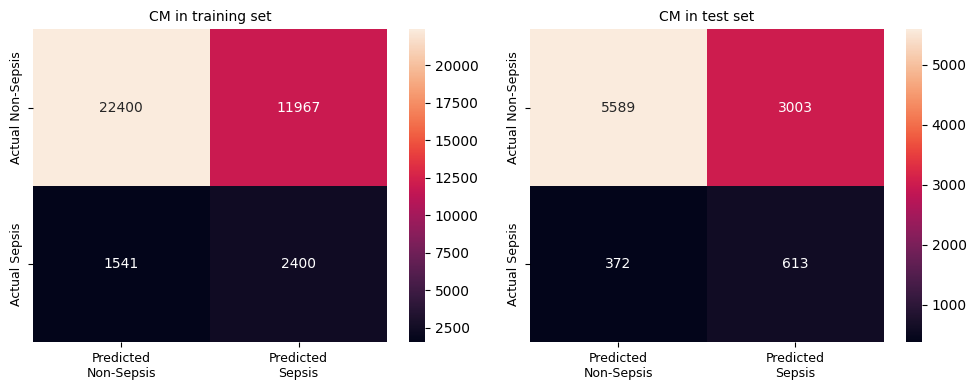

Logistic_Regression :  0.6671585065555019


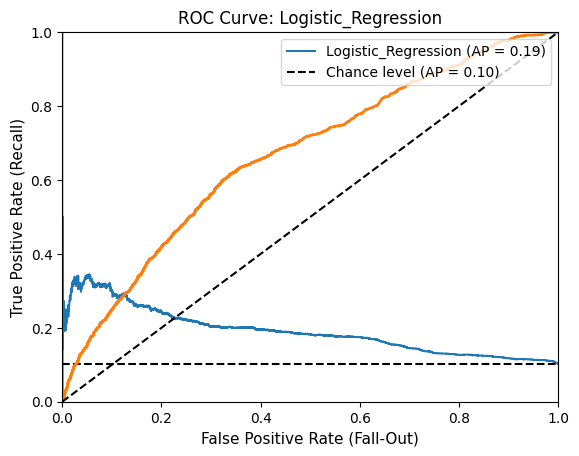

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


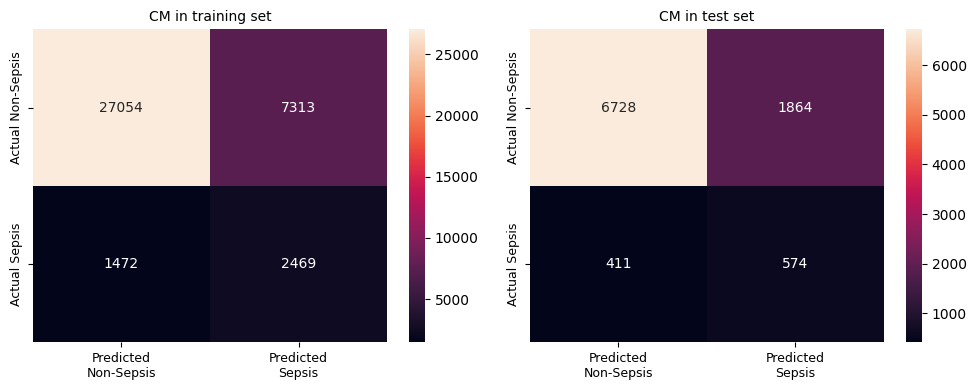

Random_Forest :  0.7483659099717362


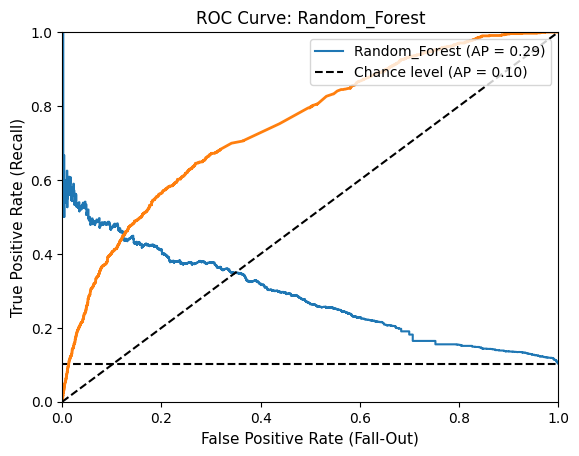

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


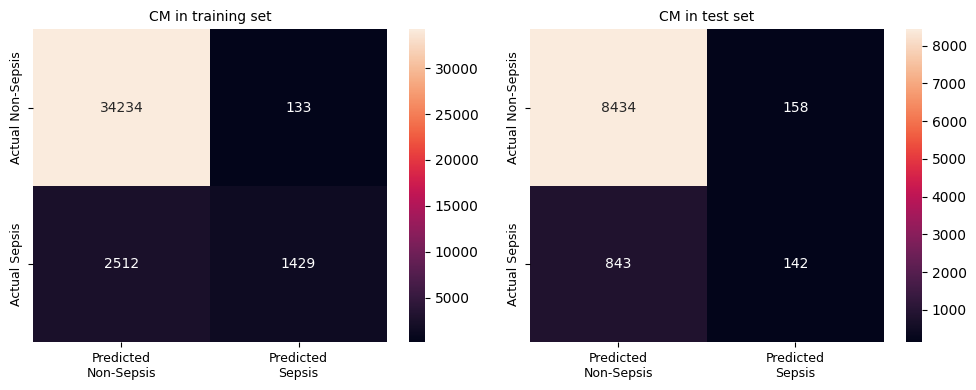

Gradient_Boosting :  0.732215778578113


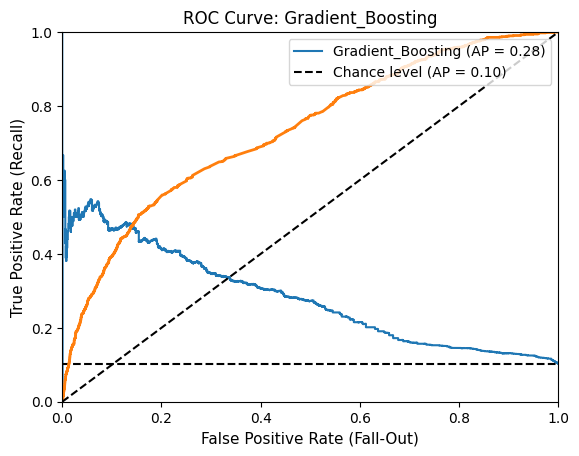

<Figure size 600x600 with 0 Axes>

In [59]:
performance_df = pd.DataFrame(columns=['Model', 'Balanced_Acc_Train', 'Balanced_Acc_Test', 'Precision_Train', 'Precision_Test', 'Recall_Train', 'Recall_Test', 'F1_Train', 'F1_Test'])

for model_name, model in candidate_models.items():
  
  y_pred_train, y_pred_test = fit_models(model)
  
  performance_scores = get_performance_scores(model, X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)
  
  new_row = pd.DataFrame([[model_name] + performance_scores], columns=performance_df.columns)
  # performance_df = performance_df.append(pd.Series([model_name] + performance_scores, index=performance_df.columns), ignore_index=True)
  
  performance_df = pd.concat([performance_df, new_row], ignore_index=True)

    
  predicted_probabilities = model.predict_proba(X_test)
  #plot_roc_curve_prec_rec(predicted_probabilities, model_name, X_test, y_test)
  plot_results(model, model_name, predicted_probabilities)

  


In [ ]:
plot_confusion_matrix(model, X_train, X_test, y_train, y_test):

In [38]:
performance_df

,Model,Balanced_Acc_Train,Balanced_Acc_Test,Precision_Train,Precision_Test,Recall_Train,Recall_Test,F1_Train,F1_Test
0,Logistic_Regression,0.630385,0.636412,0.167049,0.169524,0.608982,0.622335,0.262180,0.266464
1,Random_Forest,0.706470,0.683098,0.251142,0.234719,0.627506,0.584772,0.358718,0.334981
2,Gradient_Boosting,0.675036,0.559544,0.912361,0.414201,0.353971,0.142132,0.510055,0.211640


# Results: 

Logistic_Regression:
0.6520044579056
{'C': 0.1, 'penalty': None}



In [ ]:
load_expression(model_input_df, test_size, candidate_models)